<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# !pip install prophet

In [64]:
%pip install python-bcb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [66]:
df = pd.read_csv('../../data library/Algodao_v1.csv', sep=";")
df["Data"] = pd.to_datetime(df["Data"])
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df = df[["ds", "Cultivo", "y", "País", "Id", "Último", "Abertura", "Máxima", "Mínima"]]
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima
0,2005-01-01,Algodão,41.3763,41.0963,3.0,4376.0,4451.0,4831.0,4240.0
1,2005-02-01,Algodão,40.0096,41.2643,3.0,5030.0,4420.0,5030.0,4261.0
2,2005-03-01,Algodão,37.3086,40.0517,3.0,5303.0,5015.0,5460.0,4775.0
3,2005-04-01,Algodão,39.1540,40.9909,3.0,5800.0,5315.0,6050.0,5055.0
4,2005-05-01,Algodão,35.0431,38.6424,3.0,4864.0,5770.0,5800.0,4850.0


In [67]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2005-01-01',
                  end='2024-10-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [68]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima = clima[10:].reset_index(drop=True)
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/01/2005,153.8,24.1
1,28/02/2005,287.4,24.5
2,31/03/2005,287.4,24.5
3,30/04/2005,287.4,25.5
4,31/05/2005,287.4,25.5


In [69]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2005-01-01,Algodão,41.3763,41.0963,3.0,4376.0,4451.0,4831.0,4240.0,2.693024,153.8,24.1,41.3763
1,2005-02-01,Algodão,40.0096,41.2643,3.0,5030.0,4420.0,5030.0,4261.0,2.597839,287.4,24.5,41.3763
2,2005-03-01,Algodão,37.3086,40.0517,3.0,5303.0,5015.0,5460.0,4775.0,2.704736,287.4,24.5,40.0096
3,2005-04-01,Algodão,39.1540,40.9909,3.0,5800.0,5315.0,6050.0,5055.0,2.579180,287.4,25.5,37.3086
4,2005-05-01,Algodão,35.0431,38.6424,3.0,4864.0,5770.0,5800.0,4850.0,2.452814,287.4,25.5,39.1540


In [70]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [71]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

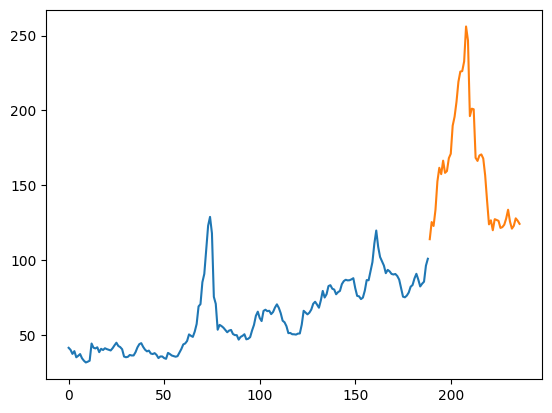

In [72]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [73]:
m = Prophet()
m.fit(train)

# m.params

23:20:21 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-10-01,89.370256,73.781999,105.415831
1,2020-11-01,90.022565,73.238739,106.519574
2,2020-12-01,91.741634,74.417514,108.334248
3,2021-01-01,96.404164,79.382051,113.085632
4,2021-02-01,98.467066,82.523196,116.136367


In [75]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,yhat
0,2020-10-01,113.9626,89.370256
1,2020-11-01,125.4194,90.022565
2,2020-12-01,122.7905,91.741634
3,2021-01-01,133.6717,96.404164
4,2021-02-01,152.5190,98.467066


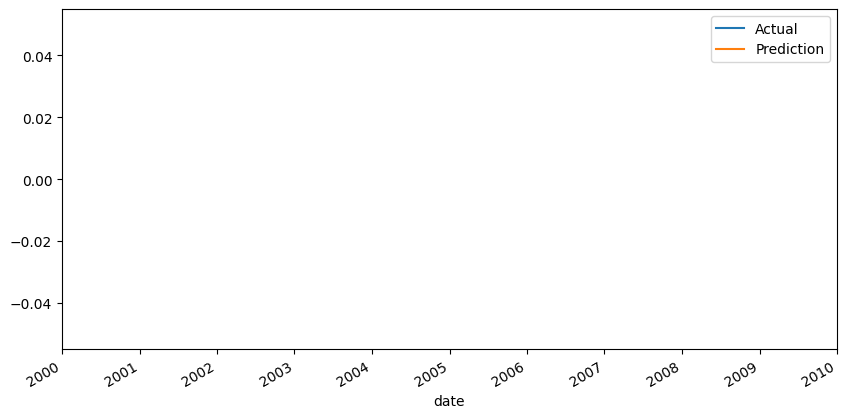

MAE: 58.65214328572185
RMSE: 70.99560134759098
MAPE: 0.33221874672512625
R-Squared: -2.4283663615460065


In [76]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [77]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-10-01,5.625790,112.5502,7058.0,7377.0,100.8865
1,2020-11-01,5.417835,124.6481,7305.0,7508.0,113.9626
2,2020-12-01,5.145586,125.1981,7917.0,7946.0,125.4194
3,2021-01-01,5.356245,134.9602,8278.0,8468.0,122.7905
4,2021-02-01,5.416494,153.2923,8971.0,9622.0,133.6717


In [79]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [80]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-10-01,111.515410,109.786794,113.089359
1,2020-11-01,123.850341,122.270801,125.564934
2,2020-12-01,124.077159,122.489368,125.902712
3,2021-01-01,137.087161,135.381032,138.710317
4,2021-02-01,155.866101,154.138432,157.443520


In [81]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-10-01,113.9626,112.5502,5.625790,111.515410
1,2020-11-01,125.4194,124.6481,5.417835,123.850341
2,2020-12-01,122.7905,125.1981,5.145586,124.077159
3,2021-01-01,133.6717,134.9602,5.356245,137.087161
4,2021-02-01,152.5190,153.2923,5.416494,155.866101


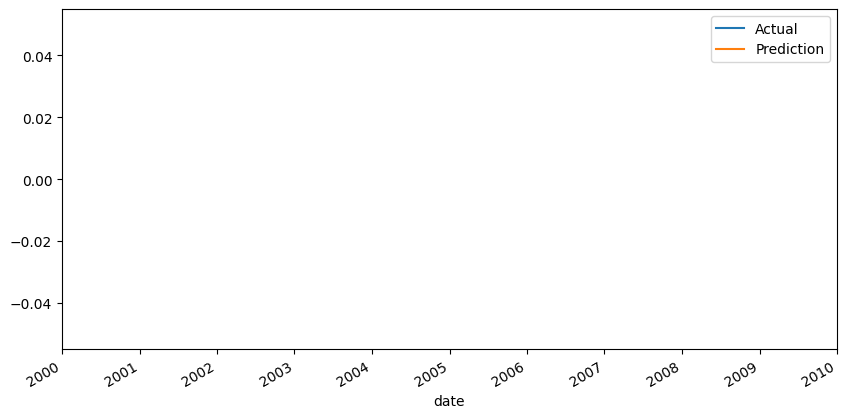

MAE: 2.160971271992704
RMSE: 2.7466793376832315
MAPE: 0.014772465241096877
R-Squared: 0.994868548104623


In [82]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

## Predict variables

In [83]:
aux_var = ['USD', 'País', 'Último', 'Máxima', 'lag_Estadual']
future_dates = m.make_future_dataframe(periods=((len(test_1))+24), freq="MS")

In [84]:
extended_df = future_dates.copy()

for i in aux_var:
    train_aux = train[['ds', i]].copy()
    train_aux.rename(columns={i:"y"}, inplace=True)

    m = Prophet()
    m.fit(train_aux)
    forecast = m.predict(future_dates)
    
    extended_df[i] = forecast["yhat"]

extended_df

23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:24 - cmdstanpy - INFO - Chain [1] start processing
23:20:24 - cmdstanpy - INFO - Chain [1] done processing
23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,USD,País,Último,Máxima,lag_Estadual
0,2005-01-01,2.327449,33.540226,4640.912357,5175.187839,29.648565
1,2005-02-01,2.215879,36.129405,5148.534969,5630.902399,33.548921
2,2005-03-01,2.318001,37.145924,4891.244981,5767.331889,35.049352
3,2005-04-01,2.298423,37.895415,4882.657260,5584.258519,35.829591
4,2005-05-01,2.319241,34.794728,4561.022370,5425.279856,36.157215
...,...,...,...,...,...,...
256,2026-05-01,6.608163,116.523603,4588.420810,4952.906962,118.862698
257,2026-06-01,6.610349,115.843047,4637.391402,4777.102333,115.793708
258,2026-07-01,6.602289,114.267947,4255.481200,4698.783956,115.416953
259,2026-08-01,6.674476,114.193472,4171.396411,4343.895601,113.466194


In [85]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

23:20:25 - cmdstanpy - INFO - Chain [1] start processing
23:20:25 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
real_data = df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']].copy()
final_date = df["ds"][-1:]
predicted_data = extended_df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][len(train)+len(test):]

real_data_2 = pd.concat([real_data, predicted_data], ignore_index=True)

In [87]:
test_2 = real_data_2[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][train_size:].reset_index(drop=True)
test_2.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-10-01,5.625790,112.5502,7058.0,7377.0,100.8865
1,2020-11-01,5.417835,124.6481,7305.0,7508.0,113.9626
2,2020-12-01,5.145586,125.1981,7917.0,7946.0,125.4194
3,2021-01-01,5.356245,134.9602,8278.0,8468.0,122.7905
4,2021-02-01,5.416494,153.2923,8971.0,9622.0,133.6717


In [88]:
final_forecast = m.predict(test_2)
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-10-01,111.515410,109.938750,113.141782
1,2020-11-01,123.850341,122.255220,125.469311
2,2020-12-01,124.077159,122.450204,125.712294
3,2021-01-01,137.087161,135.471188,138.758147
4,2021-02-01,155.866101,154.232785,157.265113


In [89]:
test_2.reset_index(inplace=True, drop=True)
test_2['y'] = test['y']
test_2.fillna(0, inplace=True)
final_df = test_2[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = final_forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-10-01,113.9626,112.5502,5.625790,111.515410
1,2020-11-01,125.4194,124.6481,5.417835,123.850341
2,2020-12-01,122.7905,125.1981,5.145586,124.077159
3,2021-01-01,133.6717,134.9602,5.356245,137.087161
4,2021-02-01,152.5190,153.2923,5.416494,155.866101


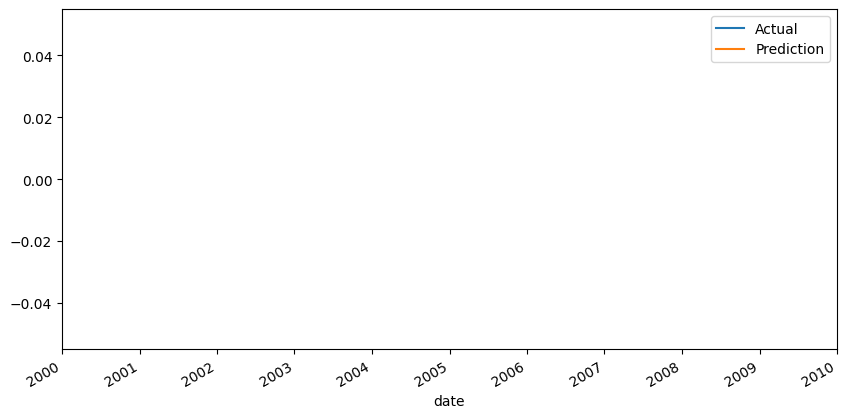

MAE: 36.677597255414604
RMSE: 61.10736192553815
MAPE: 1.5869311372212723e+17
R-Squared: 0.4368683196522545


In [90]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [94]:
final_df.to_csv('../../Algodâo/Algodao_Resultados.csv', sep=',', index=False)